In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
import matplotlib.pyplot as plt
from PIL import Image
import os
import pathlib
import random

In [3]:
path = '/content/drive/MyDrive/Dataset images breast cancer'
data_dir = pathlib.Path(path)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
class_names = np.array([item.name for item in data_dir.glob("*")])
class_names

array(['malignant', 'normal', 'benign'], dtype='<U9')

In [6]:
benignPath = pathlib.Path(os.path.join(data_dir,'benign'))
normalPath = pathlib.Path(os.path.join(data_dir,'normal'))
malignantPath = pathlib.Path(os.path.join(data_dir,'malignant'))


In [7]:
benignImageCount = len(list(benignPath.glob('*.png')))
malignantImageCount = len(list(malignantPath.glob('*.png')))
normalImageCount = len(list(normalPath.glob('*.png')))
totalImageCount = benignImageCount + malignantImageCount + normalImageCount

In [ ]:
print("Total number of Images: ", totalImageCount)
print("No. of Benign (safe) Images: {}({})".format(benignImageCount, round(benignImageCount*100/totalImageCount, 2)))
print("No. of Malignant (dangerous) Images: {}({})".format(malignantImageCount, round(malignantImageCount*100/totalImageCount, 2)))
print("No. of Normal (No Traces) Images: {}({})".format(normalImageCount, round(normalImageCount*100/totalImageCount, 2)))

In [9]:
batch_size = 32
img_height = 224
img_width = 224

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

val_data = image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation",seed=123,image_size=(img_height,img_width),batch_size=batch_size)


Found 1597 files belonging to 3 classes.
Using 1278 files for training.
Found 1597 files belonging to 3 classes.
Using 319 files for validation.


In [11]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3,activation="softmax")
])

In [12]:
model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

epochs = 2
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data,
                    batch_size=batch_size)


Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 [==============================] - 261s 5s/step - loss: 0.8946 - accuracy: 0.5642 - val_loss: 0.8024 - val_accuracy: 0.6646
Epoch 2/2
40/40 [==============================] - 106s 2s/step - loss: 0.6686 - accuracy: 0.7050 - val_loss: 0.7163 - val_accuracy: 0.6677


In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

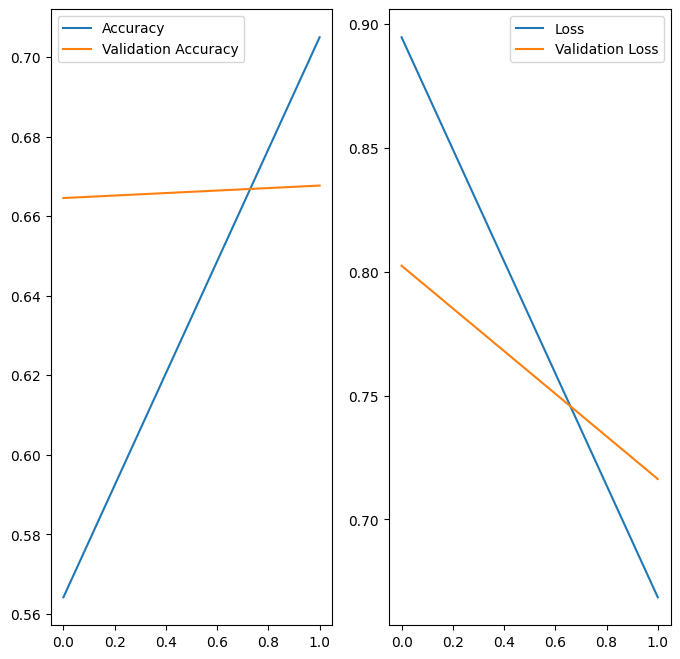

In [14]:
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [20]:
model.evaluate(val_data)

10/10 [==============================] - 15s 1s/step - loss: 0.3530 - accuracy: 0.8715


[0.35301873087882996, 0.8714733719825745]

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

1/1 [==============================] - 0s 95ms/step


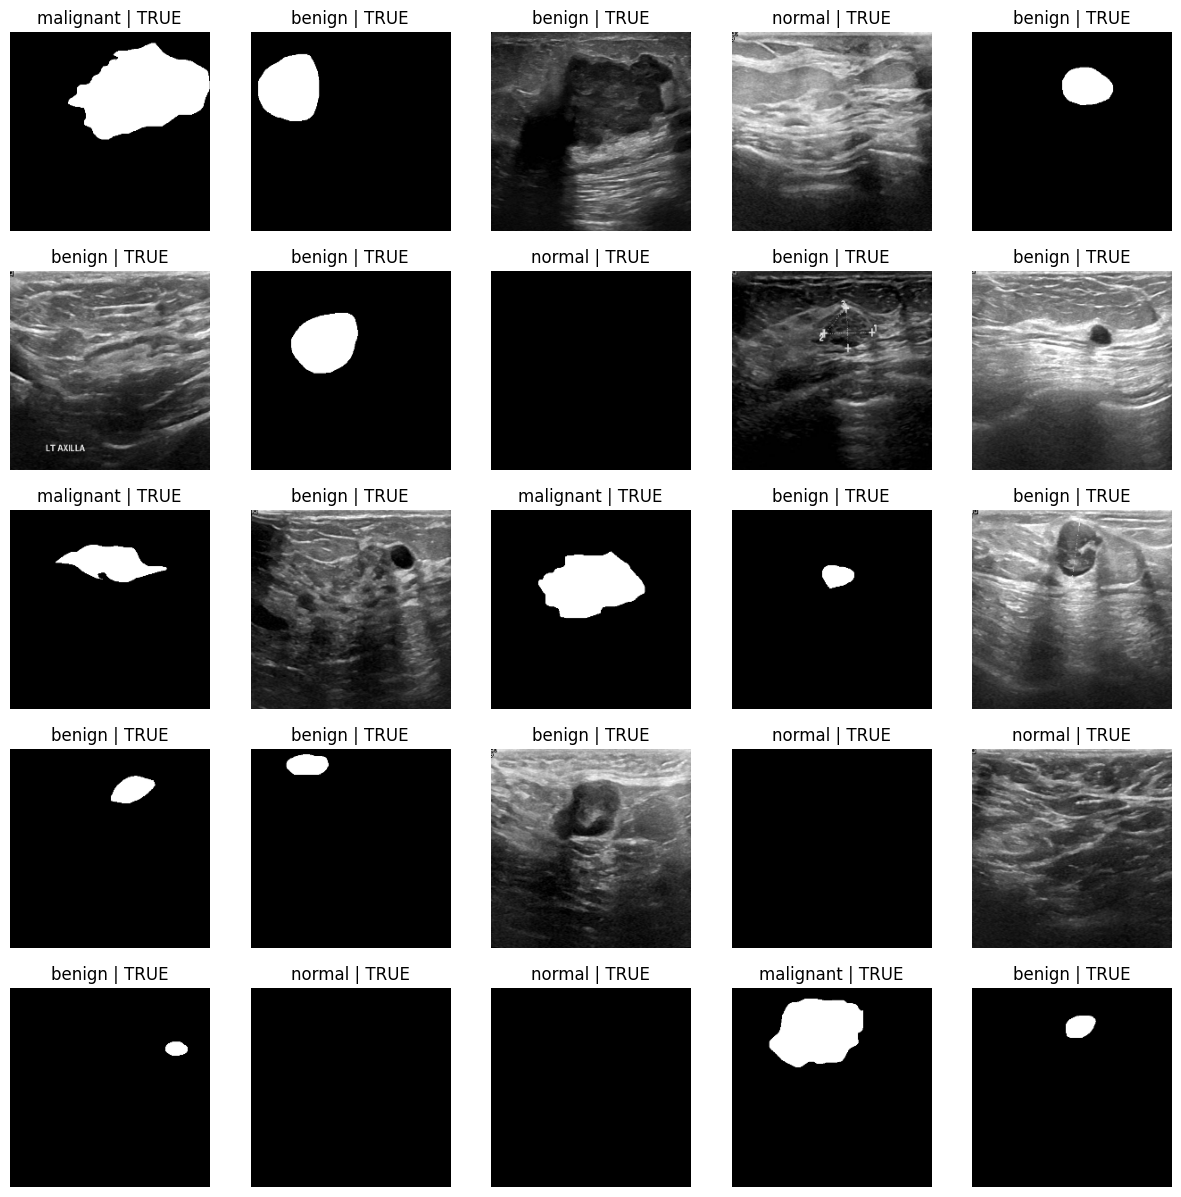

In [21]:
plt.figure(figsize=(15, 15))
class_names = val_data.class_names
result = ' | False'
for images, labels in val_data.take(1):
    for i in range(25):

        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)

        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result)
        plt.axis("off")

In [18]:
# Increase epochs
epochs = 30

# Use data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
  ]
)

# Updated model with data augmentation
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data,
                    batch_size=batch_size)


Epoch 1/30
40/40 [==============================] - 221s 5s/step - loss: 1.1950 - accuracy: 0.5532 - val_loss: 0.8141 - val_accuracy: 0.5925
Epoch 2/30
19/40 [=============>................] - ETA: 1:46 - loss: 0.8118 - accuracy: 0.6447

KeyboardInterrupt: 

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model

# Use MobileNetV2 as a base model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Use early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  restore_best_weights=True)

# Train the model
history = model.fit(train_data,
                    epochs=30,
                    validation_data=val_data,
                    batch_size=batch_size,
                    callbacks=[early_stopping])


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30
40/40 [==============================] - 100s 2s/step - loss: 0.6573 - accuracy: 0.7402 - val_loss: 0.4492 - val_accuracy: 0.8213
Epoch 2/30
40/40 [==============================] - 89s 2s/step - loss: 0.4515 - accuracy: 0.8005 - val_loss: 0.4614 - val_accuracy: 0.8088
Epoch 3/30
40/40 [==============================] - 96s 2s/step - loss: 0.4191 - accuracy: 0.8161 - val_loss: 0.4627 - val_accuracy: 0.8182
Epoch 4/30
40/40 [==============================] - 96s 2s/step - loss: 0.4419 - accuracy: 0.8177 - val_loss: 0.4152 - val_accuracy: 0.8150
Epoch 5/30
40/40 [==============================] - 90s 2s/step - loss: 0.4222 - accuracy: 0.8169 - val_loss: 0.4141 - val_accuracy: 0.8433
Epoch 6/30
40/40 [==============================] - 98s 2s/step - loss: 0.4059 - accuracy: 0.8279 - val_loss: 0.4190 - val_accuracy: 0.8276
Epoch 7/30
40/40 [==============================] - 98s 2s/step - loss: 0.3832 - accuracy: 0.839